## The purpose of the Capstone 2 project is to determine whether or not the lesion in an image is malignant or not 

import necessary libraries

In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from numpy import array, newaxis, expand_dims

Using TensorFlow backend.
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/seo/environments/my_env/lib/p

In [3]:
%run functions.py

In [4]:
import os

image_path='./Data/Images/'
imagelist=os.listdir(image_path)
pics=[file for file in imagelist]

process_path='./'
processfiles=os.listdir(process_path)

In [5]:
import pickle
def load_all_pickles(tag_name, path ,delimiter):
    processfiles=os.listdir(path)
    agg_dict=dict()
    tagged_files=[file for file in processfiles if file.split(delimiter)[0]==tag_name]
    for file in tagged_files:
        open_file=pickle.load(open(file,'rb'))
        agg_dict.update(open_file)
    return agg_dict

In [6]:
# segmented: resized, denoised, and segmented images
segmented=load_all_pickles('segmen',process_path,'_')

In [7]:
# contour_data: contour, angle of major axis, x and y of the center
contour_data=load_all_pickles('contour',process_path,'_')

Because symmetry uses both contour and segmented image data, images that either does not appear in both of the dictionary or images that has contour area of 0 should be removed

In [8]:
good_imgs=list()
for key in contour_data.keys():
    cont_check=contour_data[key]
    contourSize = cv2.contourArea(cont_check[0])
    if contourSize!=0:
        good_imgs.append(key)

In [9]:
good_imgs=[img for img in good_imgs if img in list(segmented.keys())]

In [30]:
# To give an idea of what the images will look like,
# a random sample image was chosen from the list of "good images"

sample_image=random.choice(list(good_imgs))

(Text(0.5, 1.0, 'ISIC_0029767'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

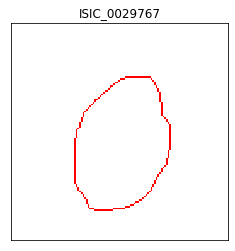

In [31]:
# Sample image of contour data
canvas=np.ones((128,128,3),np.uint8)*255
contour_sample=cv2.drawContours(canvas,contour_data[sample_image][0],-1,(255,0,0),-1)
plt.imshow(contour_sample)
plt.title(sample_image), plt.xticks([]),plt.yticks([])

(Text(0.5, 1.0, 'ISIC_0029767'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

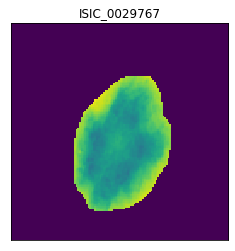

In [32]:
# Sample image of segmented data
plt.figure()
plt.imshow(segmented[sample_image])
plt.title(sample_image), plt.xticks([]),plt.yticks([])

In [33]:
# Function for calculating symmetry
def symmetry(rotated_roi,contoursize):
    imageO=rotated_roi
    imageLR=np.fliplr(rotated_roi)
    imageUD=np.flipud(rotated_roi)
    lr=mse(rotated_roi, np.fliplr(rotated_roi),contourSize)
    ud=mse(rotated_roi, np.flipud(rotated_roi),contourSize)
    return lr,ud

In [14]:
sym_dict=dict()
cont_dict=dict()
for key in good_imgs:
    contourSize = cv2.contourArea(contour_data[key][0])
    angle=contour_data[key][1]
    a=contour_data[key][2]
    b=contour_data[key][3]
    
    sym_check=segmented[key]
    label='_'.join(key.split('_')[0:2])
    rotated_roi=rotate_bound(sym_check,angle,a,b)
    lr,ud=symmetry(rotated_roi,contourSize)
    sym_dict[label]=np.mean([lr,ud])

In [15]:
len(sym_dict)

17984

In [16]:
pickle.dump(sym_dict, open('symmetry_UNEt.p',"wb"))

In [17]:
# orig: image that went through only resizing process
orig=load_all_pickles('orig',process_path,'_')

In [18]:
# Color analysis
# Required data: original images
# Takes Red, Green, Blue channel and calculate standard deviation in each channel

blue_dict=dict()
green_dict=dict()
red_dict=dict()
for key in good_imgs:
    colorcheck=np.array(orig[key])
    label='_'.join(key.split('_')[0:2])
    color = ('b','g','r')
    #fig=plt.figure()
    zerovalues=list()
    #ax=fig.add_subplot(2,1,1)
    for i,col in enumerate(color):
        histr = cv2.calcHist([colorcheck],[i],None,[256],[0,256])
        #ax.plot(histr,color = col)
        zerovalues.append(histr[0])
        histr=histr[1:]
        #plt.xlim([0,255])
        #ax.set_yscale('log')
        if col=='b':
            blue_dict[label]=histr.std()
        if col=='g':
            green_dict[label]=histr.std()
        if col=='r':
            red_dict[label]=histr.std()

In [19]:
len(blue_dict),len(green_dict),len(red_dict)

(17984, 17984, 17984)

In [20]:
pickle.dump(blue_dict, open('blue_UNET.p',"wb"))
pickle.dump(green_dict, open('green_UNET.p',"wb"))
pickle.dump(red_dict, open('red_UNET.p',"wb"))

In [21]:
# resized: same as segmented image but includes the background as well

resized=load_all_pickles('resized',process_path,'_')

(Text(0.5, 1.0, 'ISIC_0029767'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

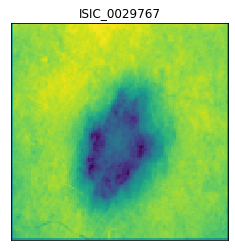

In [34]:
# Sample image of segmented data
plt.figure()
plt.imshow(resized[sample_image].squeeze())
plt.title(sample_image), plt.xticks([]),plt.yticks([])

In [37]:
image_list=[img for img in resized.keys() if img in good_imgs]

In [38]:
# Required data: contour, resized

border_dict=dict()

for key in good_imgs:
    try:
        border_check=resized[key]
        cnt=contour_data[key][0]
        H=128; W=128
        h=6; w=6
        tots_gradient=[]
        for point in cnt[:,0]:
            x=point[0]
            y=point[1]
            #print(x,y)
            y1=y-h; y2=y+h
            x1=x-w; x2=x+w
            if y1<0:
                y1=0
            if y2>H:
                y2=H
            if x1<0:
                x1=0
            if x2>W:
                x2=W
            #print(x1,y1,x2,y2)
            crop_img = border_check.squeeze()[y1:y2, x1:x2].copy()
            mag,ang,gx,gy=get_mag_ang(crop_img)
            tots_gradient.append(mag.mean())
        border_dict[key]=np.mean(tots_gradient)
    except:
        continue

In [39]:
len(border_dict)

17984

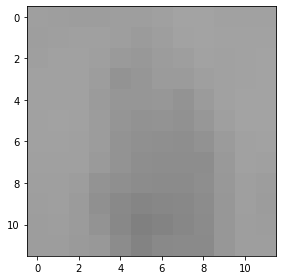

In [40]:
imshow(crop_img)

In [41]:
pickle.dump(border_dict, open('border_UNET.p',"wb"))

In [1]:
import pickle
symmetry_dict=pickle.load(open('symmetry_UNEt.p', 'rb'))
blue_dict=pickle.load(open('blue_UNET.p', 'rb'))
green_dict=pickle.load(open('green_UNET.p', 'rb'))
red_dict=pickle.load(open('red_UNET.p', 'rb'))
border_dict=pickle.load(open('border_UNET.p', 'rb'))

In [2]:
meta_df=pickle.load(open('isic_data','rb'))

In [3]:
from collections import defaultdict

dd=defaultdict(list)
for d in (symmetry_dict, border_dict, red_dict, green_dict, blue_dict):
    for key, value in d.items():
        dd[key].append(value)

In [4]:
len(dd)

17984

In [5]:
dd['ISIC_0026298']

[2434222.8408521325, 0.097849436, 118.18659, 116.17678, 133.09866]

In [6]:
import pandas as pd
df_raw=pd.DataFrame(dd)
df_raw=df_raw.transpose()
df_raw.columns=['symmetry','border','red','green','blue']

In [7]:
df_raw

,symmetry,border,red,green,blue
ISIC_0005889,3.797314e+04,0.180041,149.063934,162.829437,174.777191
ISIC_0030487,6.032928e+05,0.063710,77.295006,94.697449,94.682220
ISIC_0031103,1.291171e+03,0.046612,156.743484,192.986725,189.846237
ISIC_0027853,4.198372e+03,0.067160,49.306885,78.382271,78.388977
ISIC_0013127,1.656603e+05,0.180363,135.603577,124.176094,227.685165
ISIC_0006552,6.802395e+03,0.155382,133.577652,174.282440,162.448593
ISIC_0026054,3.632420e+03,0.038869,93.762276,126.954094,254.920990
ISIC_0025976,1.437426e+03,0.063052,130.710358,151.332870,149.293152
ISIC_0011549,3.085956e+03,0.085724,62.803650,68.128220,75.496216
ISIC_0025491,4.214647e+03,0.081141,59.135468,64.704453,71.399788


In [8]:
ben_mal=meta_df[['name','meta.clinical.benign_malignant']]
ben_mal=ben_mal.rename(columns={'meta.clinical.benign_malignant':'malig_benign'})

In [9]:
import numpy as np
ben_mal_list=list()
for malignancy in ben_mal['malig_benign']:
    if malignancy == 'benign':
        ben_mal_list.append(0)
    elif malignancy == 'malignant':
        ben_mal_list.append(1)
    else:
        ben_mal_list.append(np.NaN)

In [10]:
ben_mal['malig_benign']=ben_mal_list

In [11]:
ben_mal=ben_mal.set_index('name')
del ben_mal.index.name

In [12]:
new_df=df_raw.join(ben_mal,how='outer')
new_df=new_df.dropna()

In [13]:
new_df

,symmetry,border,red,green,blue,malig_benign
ISIC_0000000,3.060597e+03,0.090472,169.260056,83.258881,109.840569,0.0
ISIC_0000001,8.297035e+02,0.133258,167.868790,197.507538,206.749573,0.0
ISIC_0000002,2.161214e+03,0.044267,73.881050,76.923767,137.701797,1.0
ISIC_0000003,3.889772e+03,0.087672,121.118683,127.288406,149.990173,0.0
ISIC_0000004,2.748019e+03,0.294333,318.564331,318.579376,319.799255,1.0
ISIC_0000005,3.865132e+03,0.039265,91.929420,99.219696,110.995247,0.0
ISIC_0000006,2.392168e+03,0.054350,100.248177,133.984207,162.575378,0.0
ISIC_0000007,2.155053e+03,0.072146,104.805283,134.082352,157.786072,0.0
ISIC_0000009,3.259229e+03,0.051923,85.616745,94.998863,122.118164,0.0
ISIC_0000010,2.417131e+03,0.076539,152.956070,170.335907,192.547516,0.0


In [14]:
ben=new_df[new_df['malig_benign']==0]
mal=new_df[new_df['malig_benign']==1]

In [15]:
ben.describe()

,symmetry,border,red,green,blue,malig_benign
count,1.424800e+04,14248.000000,14248.000000,14248.000000,14248.000000,14248.0
mean,1.991323e+05,0.088156,127.815680,146.036482,161.924805,0.0
std,1.492189e+06,0.078164,36.531920,41.969562,47.059918,0.0
min,1.734601e+02,0.004264,20.928068,27.456913,25.945187,0.0
25%,1.714072e+03,0.041735,101.889553,115.268259,133.011765,0.0
50%,2.721307e+03,0.061824,127.663589,146.682304,158.748253,0.0
75%,5.314435e+03,0.103022,151.926685,176.281803,185.978828,0.0
max,6.309134e+07,0.661101,402.554535,310.986664,605.751892,0.0


In [16]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [17]:
import matplotlib.pyplot as plt
def ecdf_easy(df,column):
    _mean=np.mean(df[column])
    _std=np.std(df[column])
    _size=round(len(df[column])*0.2)
    samples=np.random.normal(_mean,_std,size=_size)
    
    x_,y_=ecdf(df[column])
    x_norm,y_norm=ecdf(samples)
    
    return x_norm, y_norm
    #plt.plot(x_norm,y_norm)
    #plt.plot(x_,y_, marker='.',linestyle='none')

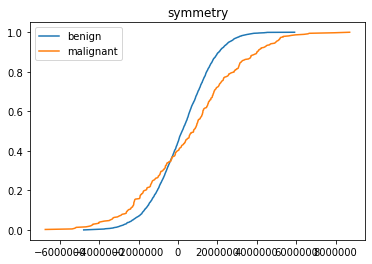

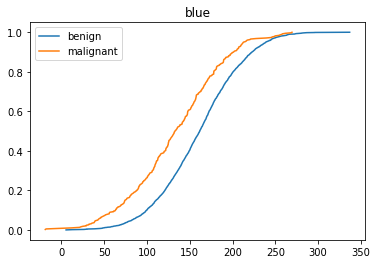

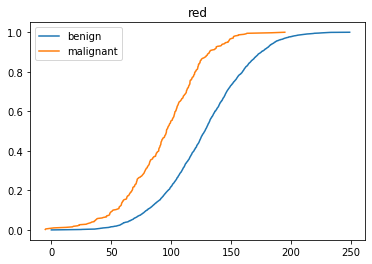

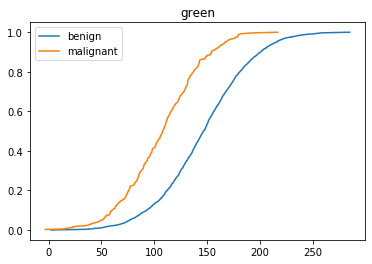

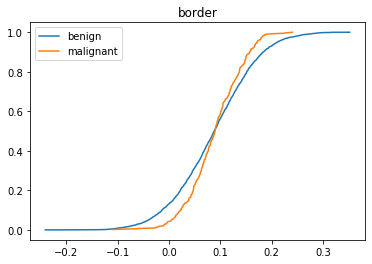

In [18]:
for feature in ['symmetry','blue','red','green','border']:
    xmal,ymal=ecdf_easy(mal,feature)
    xben,yben=ecdf_easy(ben,feature)
    plt.figure()
    plt.plot(xben,yben, label='benign')
    plt.plot(xmal,ymal, label='malignant')
    plt.title(feature)
    plt.legend()

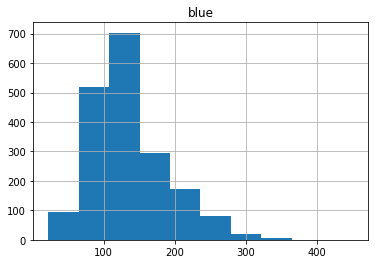

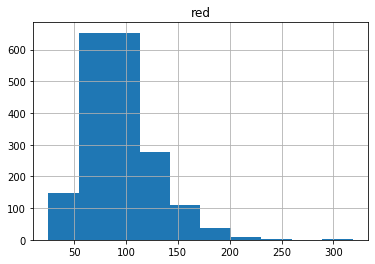

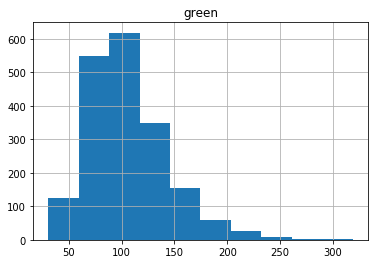

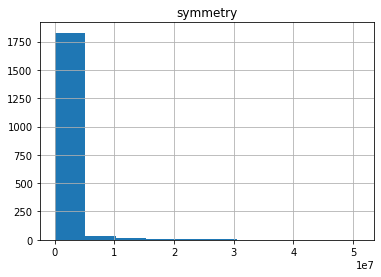

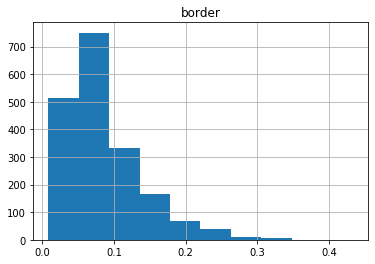

In [19]:
malig_blue=mal.hist('blue')
malig_red=mal.hist('red')
malig_green=mal.hist('green')
malig_sym=mal.hist('symmetry')
malig_bor=mal.hist('border')

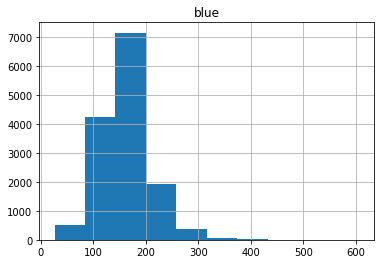

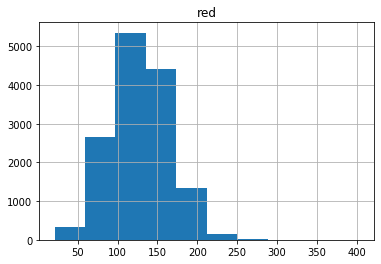

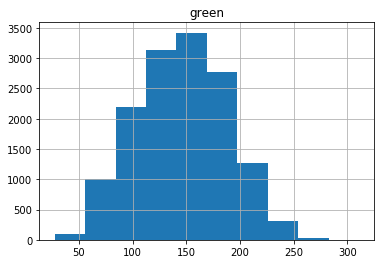

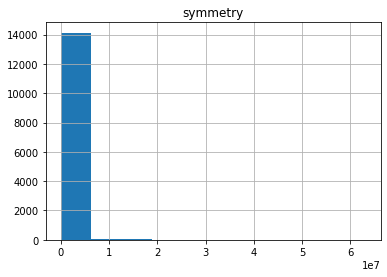

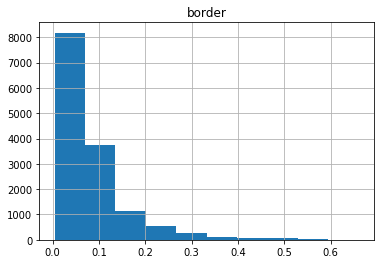

In [20]:
ben_blue=ben.hist('blue')
ben_red=ben.hist('red')
ben_green=ben.hist('green')
ben_sym=ben.hist('symmetry')
ben_bor=ben.hist('border')


In [21]:
from scipy import stats

def check_if_significant(data1,data2,alpha=0.01):
    p_val=stats.ttest_ind(data1,data2)[1]
    if p_val < alpha:
        print('significant ', p_val)
    else:
        print('insignificant ', p_val)

In [22]:
def check_every_element(element):
    return check_if_significant(mal[element],ben[element])

In [23]:
for name in ['symmetry','border','red','green','blue']:
    print(name)
    check_every_element(name)

symmetry
significant  5.991042459216647e-15
border
insignificant  0.24626806055712488
red
significant  6.699422678812652e-298
green
significant  0.0
blue
significant  1.267180515574567e-111


In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
features = new_df.drop('malig_benign',axis=1)
labels = new_df['malig_benign']

In [25]:
feature_list=list(features.columns)
feature_list

['symmetry', 'border', 'red', 'green', 'blue']

In [26]:
import numpy as np
features=np.array(features)

In [27]:
train_features, test_features, train_labels, test_labels = train_test_split(
                                                                    features,
                                                                    labels,
                                                                    test_size = 0.25,
                                                                    random_state=42)

In [28]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (12105, 5)
Training Labels Shape: (12105,)
Testing Features Shape: (4035, 5)
Testing Labels Shape: (4035,)


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
# number of leaves and dept sensitive
#clf_forest=RandomForestClassifier(n_estimators=100,random_state=42)
clf_forest=RandomForestClassifier(bootstrap=True, class_weight='balanced',
 
criterion='gini', max_depth=9, max_features=0.6,
 
max_leaf_nodes=None, min_impurity_decrease=0.0,
 
min_impurity_split=None, min_samples_leaf=1,
 
min_samples_split=2, min_weight_fraction_leaf=0.0,
 
n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
 
verbose=0, warm_start=False)
clf_forest_enc=OneHotEncoder(categories='auto')
clf_forest_lm=LogisticRegression(solver='lbfgs',max_iter=1000)

In [30]:
clf_forest.fit(train_features,train_labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features=0.6,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [31]:
clf_forest_enc.fit(clf_forest.apply(train_features))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [32]:
label_pred_forest=clf_forest.predict(test_features)

In [33]:
from sklearn.tree import DecisionTreeClassifier
clf_decision=DecisionTreeClassifier(random_state=42)

In [34]:
clf_decision.fit(train_features,train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [35]:
label_pred_decision=clf_decision.predict(test_features)

In [36]:
import lightgbm as lgb
d_train = lgb.Dataset(train_features, train_labels)
params = {}
params['learning_rate'] = 0.001
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 20
params['max_depth'] = 10
clf_lgb = lgb.train(params, d_train, 10000)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
y_pred=clf_lgb.predict(test_features)
max_recall=0
thresh=0
for i in range(0,len(test_features)):
    if y_pred[i]>=0.2:       # setting threshold to .5
        y_pred[i]=1
    else:  
        y_pred[i]=0    
recall = recall_score(y_pred, test_labels)
accuracy = accuracy_score(y_pred, test_labels)
    #recall = accuracy_score(y_pred, test_labels)

print("lightgbm Recall:",recall_score(test_labels, y_pred) )
print("lightgbm Accuracy:",accuracy_score(test_labels, y_pred))
print("lightgbm Precision:",precision_score(test_labels, y_pred))
print("lightgbm ROC AUC score:",roc_auc_score(test_labels, y_pred))

In [ ]:
pd.DataFrame(sorted(zip(clf_lgb.feature_importance(),feature_list)),columns=['Value','Feature'])

In [ ]:
from sklearn import metrics
print("Random forest Recall:",metrics.recall_score(test_labels, label_pred_forest))
print("Random forest Accuracy:",metrics.accuracy_score(test_labels, label_pred_forest))
print("Random forest precision:",metrics.precision_score(test_labels, label_pred_forest))
print("Random forest ROC AUC score:",roc_auc_score(test_labels, label_pred_forest))

print("Decision tree Recall:",metrics.recall_score(test_labels, label_pred_decision))
print("Decision tree Accuracy:",metrics.accuracy_score(test_labels, label_pred_decision))
print("Decision tree precision:",metrics.precision_score(test_labels, label_pred_decision))
print("Decision tree ROC AUC score:",roc_auc_score(test_labels, label_pred_decision))

In [ ]:
true_positive=0
false_negative=0
false_positive=0
for i in range(len(test_labels)):
    real=test_labels[i]
    pred=y_pred[i]
    if real!=pred:
        if real>pred:
            false_negative=false_negative+1
        if real<pred:
            false_positive=false_positive+1
    else:
        true_positive=true_positive+1
print(true_positive, false_positive, false_negative)        

In [ ]:
# ROC
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc
roc_train_all, roc_test_all, roc_train_all_class, roc_test_all_class = train_test_split(
                                                                    features,
                                                                    labels,
                                                                    test_size = 0.25,
                                                                    random_state=42)
models = [

    {
        'label' : 'RandomForestClassifier_params',
        'model': clf_forest,
        'roc_train': roc_train_all,
        'roc_test': roc_test_all,
        'roc_train_class': roc_train_all_class,        
        'roc_test_class': roc_test_all_class, 
    },
    {
        'label' : 'DecisionTreeClassifier_params',
        'model': clf_decision,
        'roc_train': roc_train_all,
        'roc_test': roc_test_all,
        'roc_train_class': roc_train_all_class,        
        'roc_test_class': roc_test_all_class, 
    },
        
]

import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(8,6))

for m in models:
    m['model'].probability = True
    probas = m['model'].fit(m['roc_train'], m['roc_train_class']).predict_proba(m['roc_test'])
    fpr, tpr, thresholds = roc_curve(m['roc_test_class'], probas[:, 1])
    roc_auc  = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))



plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

In [ ]:
feature_imp_forest = pd.Series(clf_forest.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp_forest

In [ ]:
feature_imp_decision = pd.Series(clf_decision.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp_decision